# Final Project

Ok, so today we'll be working with the transactions, product, and hh_demographic tables in the project_data folder.

* First, read in the transactions data.

* Read in the only columns `household_key`, `BASKET_ID`, `DAY`, `PRODUCT_ID`, `QUANTITY`, and `SALES_VALUE`.

* Convert `DAY`, `QUANTITY`, and `PRODUCT_ID` to the smallest appropriate integer types.


In [1]:
import pandas as pd
import numpy as np

In [2]:
transactions = pd.read_csv('../project_data/project_transactions.csv', 
                           usecols=['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE'], 
                           dtype={'DAY':'Int16'})

In [3]:
# Use the following snippet to create a Date Column.

transactions = (
    transactions
    .assign(date = (pd.to_datetime("2016", format='%Y') 
                    + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + " days"))
           )
    .drop(["DAY"], axis=1)
)

In [4]:
transactions.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


## TIME BASED ANALYSIS

* Plot the sum of sales by month. Are sales growing over time?
* Next, plot the same series after filtering down to dates April 2016 and October 2017.
* Then, plot the sum of monthly sales in 2016 vs the monthly sales 2017.
* Finally, plot total sales by day of week.

<AxesSubplot:xlabel='date'>

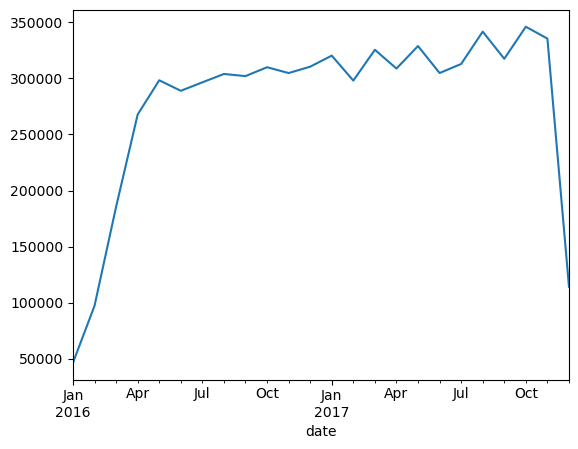

In [5]:
# 1

(transactions
 .set_index('date')
 .loc[:, 'SALES_VALUE']
 .resample('M')
 .sum()
 .plot()
)

<AxesSubplot:xlabel='date'>

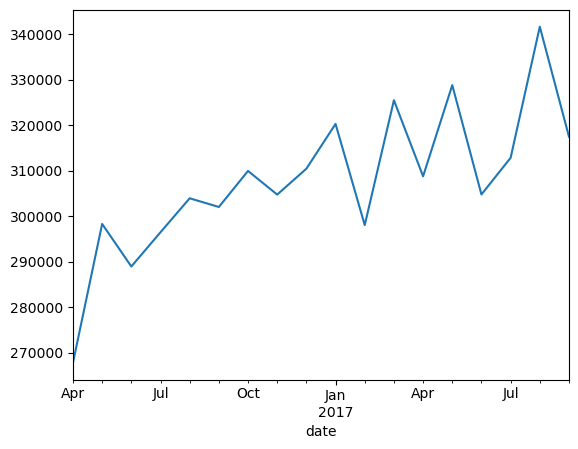

In [6]:
# 2

(transactions
 .set_index('date')
 .loc['2016-04':'2017-09', 'SALES_VALUE']
 .resample('M')
 .sum()
 .plot()
)

<AxesSubplot:xlabel='date'>

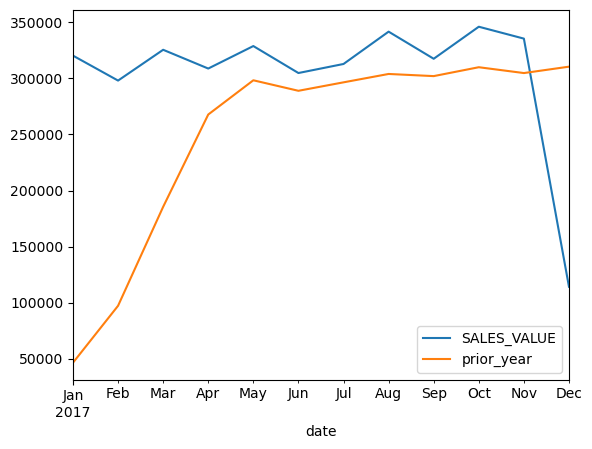

In [7]:
# 3

(transactions
 .set_index('date')
 .loc[:, ['SALES_VALUE']]
 .resample('M')
 .sum()
 .assign(prior_year = lambda x: x['SALES_VALUE'].shift(12))
 .loc['2017'].plot()
)

<AxesSubplot:xlabel='date'>

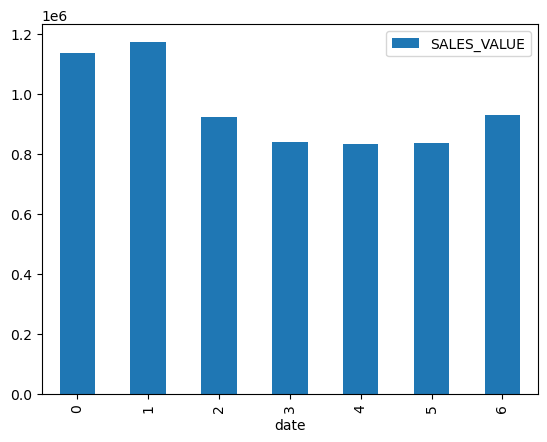

In [8]:
# 4

(transactions
 .groupby(transactions['date'].dt.dayofweek)
 .agg({'SALES_VALUE':'sum'})
 .plot.bar()
)

# DEMOGRAPHICS

* Read in the `hh_demographic.csv` file, but only the columns `AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`. Convert the appropriate columns to the category dtype.


* Then group the transactions table by household_id, and calculate the sum of SALES VALUE by household.


* Once you've done that, join the demographics DataFrame to the aggregated transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc (in separate charts).


* Then, create a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`. Which of our demographics have the highest average sales?


In [9]:
# 1

demographic = pd.read_csv('../project_data/hh_demographic.csv', 
                          usecols=['AGE_DESC', 'INCOME_DESC', 'household_key', 'HH_COMP_DESC'], 
                          dtype={'AGE_DESC':'category', 'INCOME_DESC':'category', 'HH_COMP_DESC':'category', 'household_key':'Int16'})

demographic.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [10]:
# 2

household_sales = transactions.groupby('household_key').agg({'SALES_VALUE':'sum'})

In [14]:
# 3

household_demographic = demographic.merge(household_sales, how='inner', on='household_key')
household_demographic

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key,SALES_VALUE
0,65+,35-49K,2 Adults No Kids,1,4330.16
1,45-54,50-74K,2 Adults No Kids,7,3400.05
2,25-34,25-34K,2 Adults Kids,8,5534.97
3,25-34,75-99K,2 Adults Kids,13,13190.92
4,45-54,50-74K,Single Female,16,1512.02
...,...,...,...,...,...
663,45-54,100-124K,Unknown,2087,7832.74
664,25-34,35-49K,Single Female,2088,4905.71
665,35-44,Under 15K,1 Adult Kids,2092,2290.54
666,45-54,50-74K,2 Adults No Kids,2094,3055.52


<AxesSubplot:xlabel='AGE_DESC'>

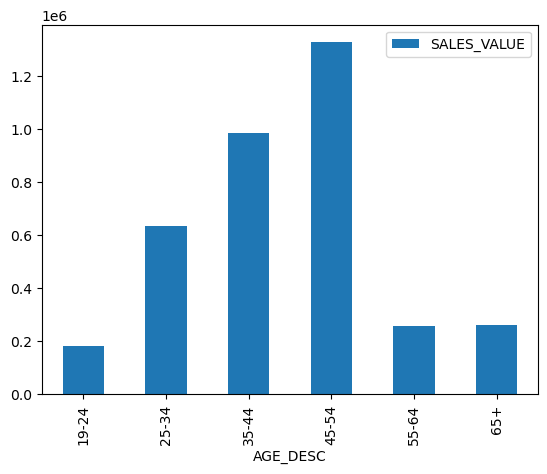

In [16]:
# 4

household_demographic.groupby('AGE_DESC').agg({'SALES_VALUE':'sum'}).plot.bar()

<AxesSubplot:xlabel='INCOME_DESC'>

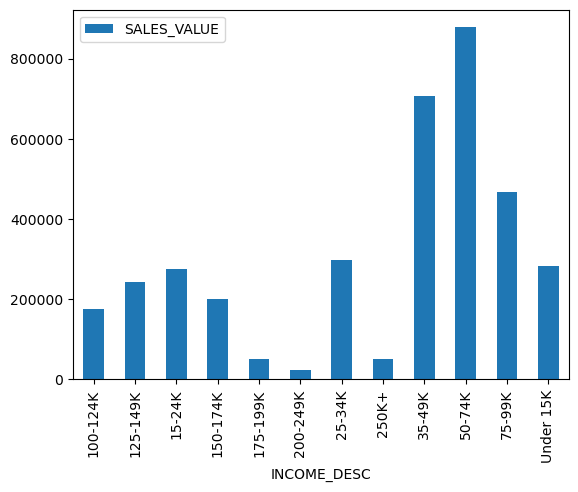

In [17]:
household_demographic.groupby('INCOME_DESC').agg({'SALES_VALUE':'sum'}).plot.bar()

In [26]:
# 5

(household_demographic
 .pivot_table(index='AGE_DESC', columns='HH_COMP_DESC', values='SALES_VALUE', aggfunc='mean')
 .style.background_gradient(cmap='RdYlGn', axis=0)
)

HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown
AGE_DESC,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000


# PRODUCT DEMOGRAPHICS

* Read in the product csv file.

* Only read in product_id and department from product (consider converting columns).

* Join the product DataFrame to transactions and demographics tables, performing an inner join when joining both tables.

* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. Which category does our youngest demographic perform well in?



In [32]:
# 1 & 2

product = pd.read_csv('../project_data/product.csv', 
                      usecols=['PRODUCT_ID', 'DEPARTMENT'], 
                      dtype={'DEPARTMENT':'category'})

product.head()

,PRODUCT_ID,DEPARTMENT
0,25671,GROCERY
1,26081,MISC. TRANS.
2,26093,PASTRY
3,26190,GROCERY
4,26355,GROCERY


In [37]:
# 3

transactions_demographic_product = (transactions
                                    .merge(demographic, how='inner', on='household_key')
                                    .merge(product, how='inner', on='PRODUCT_ID'))

transactions_demographic_product.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date,AGE_DESC,INCOME_DESC,HH_COMP_DESC,DEPARTMENT
0,1364,26984896261,842930,1,2.19,2016-01-01,65+,100-124K,Single Female,GROCERY
1,304,27950201718,842930,1,1.67,2016-03-21,25-34,50-74K,2 Adults No Kids,GROCERY
2,575,34186568032,842930,1,1.67,2017-04-29,35-44,50-74K,Single Female,GROCERY
3,77,28023861855,842930,3,5.00,2016-03-27,35-44,100-124K,2 Adults Kids,GROCERY
4,454,42136182098,842930,1,1.67,2017-11-29,55-64,35-49K,Single Male,GROCERY


In [43]:
# 4

(transactions_demographic_product
 .pivot_table(index='AGE_DESC', 
              columns='DEPARTMENT', 
              values='SALES_VALUE', 
              aggfunc='sum')
 .T
 .style.background_gradient(cmap='RdYlGn', axis=1)
)

# Spirits

AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


# EXPORT

Finally, export your pivot table to an excel file. Make sure to provide a sheet name.

In [ ]:
(transactions_demographic_product
 .pivot_table(index='AGE_DESC', 
              columns='DEPARTMENT', 
              values='SALES_VALUE', 
              aggfunc='sum')
 .T
 .style.background_gradient(cmap='RdYlGn', axis=1)
 .to_excel('demographic_category_sales,xlsx', sheet_name='sales_pivot')
)